In [16]:
import torch.nn as nn
import torch

class VQVAE(nn.Module):
    def __init__(self, num_hidden=64, num_embeddings=10):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(num_hidden)
        self.decoder = Decoder(num_hidden)
        self.quantizer = VectorQuantizer(num_embeddings=num_embeddings, embedding_dim=num_hidden)

    def forward(self,x):
        x = self.encoder(x)
        x, vq_loss, idxes = self.quantizer(x)
        x = self.decoder(x)
        return x, vq_loss, idxes

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    # written by ChatGPT
    def forward(self, x):
        b, c, h, w = x.shape
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)  # [B*H*W, C]

        distances = (flat_x ** 2).sum(dim=1, keepdim=True) - 2 * flat_x @ self.embedding.weight.T + (self.embedding.weight ** 2).sum(dim=1)

        encoding_indices = torch.argmin(distances, dim=1)  # [B*H*W]
        quantized = self.embedding(encoding_indices).view(b, h, w, c).permute(0, 3, 1, 2)  # [B, C, H, W]

        e_latent_loss = ((quantized.detach() - x) ** 2).mean()  # Loss for embedding
        q_latent_loss = ((quantized - x.detach()) ** 2).mean()  # Loss for input commitment
        vq_loss = e_latent_loss + self.beta * q_latent_loss

        quantized = x + (quantized - x).detach()

        return quantized, vq_loss, encoding_indices.view(b,h,w)

class Encoder(nn.Module):
    def __init__(self, num_hidden=64):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.res1 = ResBlock(num_hidden)
        self.res2 = ResBlock(num_hidden)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)
        x = self.res2(x)

        return x

class Decoder(nn.Module):
    def __init__(self, num_hidden=64):
        super(Decoder, self).__init__()

        self.res1 = ResBlock(num_hidden)
        self.res2 = ResBlock(num_hidden)
        self.conv1 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.res1(x)
        x = self.res2(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super(ResBlock, self).__init__()
        self.resblock = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        return x + self.resblock(x)

In [6]:
import torchvision
import torchvision.transforms as transforms

# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def vqvae_loss(recon_x, x, vq_loss):
    recon_loss = nn.functional.mse_loss(recon_x, x)
    return recon_loss + vq_loss

In [ ]:
# Training loop (single iteration)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vq = VQVAE()

vq.to(device)

lr = 2e-4
optim = torch.optim.Adam(vq.parameters(), lr=lr)

cnt = 0
while cnt < 10000:
  for i, (inputs, _) in enumerate(trainloader):
      cnt += 1
      # Move data to device if using GPU
      x = inputs.to(device)  # Shape: [batch_size, 3, 32, 32]

      # Forward pass
      recon_x, vq_loss = vq(x)

      # Compute loss
      loss = vqvae_loss(recon_x, x, vq_loss) #dec_in, encoding)

      # Backpropagation
      optim.zero_grad()
      loss.backward(retain_graph=True)
      optim.step()

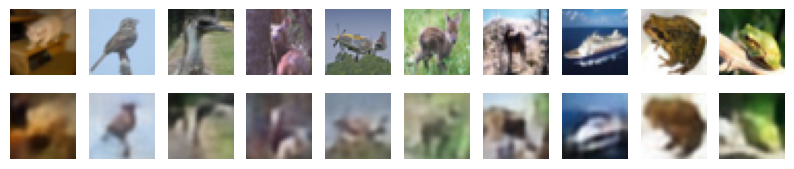

'\n# Generate an image using a uniform prior\nwith torch.no_grad():\n    b = 128\n    h,w = 8,8\n    random_indices = torch.randint(0, vq.quantizer.embedding.num_embeddings, (b * h * w,), device=device)\n    random_embeddings = vq.quantizer.embedding(random_indices).reshape(b, h, w, -1)\n    random_embeddings = random_embeddings.permute(0, 3, 1, 2)  # [B, C, H, W]\n    generated_img = vq.decoder(random_embeddings)[0]\n\n# Plot the images\nplot_images(example_img, recon_img, generated_img)\n'

In [131]:
#plot generated images
def denormalize(img):
    """Denormalize an image from [-1, 1] to [0, 1] for visualization."""
    return (img * 0.5 + 0.5).clamp(0, 1)

cnt = 0

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i, (inputs, _) in enumerate(trainloader):
  break
while cnt < 10:
    # Move data to device if using GPU
    x = inputs.to(device)  # Shape: [batch_size, 3, 32, 32]

    # Select an example image and reconstruction
    idx = int(np.random.randint(x.shape[0]))
    example_img = x[idx]
    with torch.no_grad():
        recon_x, vq_loss = vq(x)
    recon_img = recon_x[idx]

    plt.sca(ax[1][cnt])
    plt.imshow(np.transpose(denormalize(recon_img).detach().cpu().numpy(), (1, 2, 0)))
    #plt.title("Reconstructed")
    plt.axis('off')

    plt.sca(ax[0][cnt])
    plt.imshow(np.transpose(denormalize(example_img).detach().cpu().numpy(), (1, 2, 0)))
    #plt.title("Original")
    plt.axis('off')
    cnt += 1
plt.show()

In [23]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

vq_new = VQVAE()
vq_new.load_state_dict(vq.state_dict())
vq_new.to(device)

# written by ChatGPT
# Path to save the latent dataset
latent_dataset_path = "vae_latents_dataset.pt"


def save_latent_dataset(vq_model, trainloader, device, save_path=latent_dataset_path):
    """
    Construct and save a dataset of VAE latents.

    Args:
        vq_model: The trained VQ-VAE model.
        trainloader: Dataloader for the training data.
        device: Device to run the model on.
        save_path: Path to save the latent dataset.
    """
    vq_model.eval()
    all_latents = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in trainloader:
            inputs = inputs.to(device)
            with torch.no_grad():
              _, _, latents = vq_new(inputs)  # Get latents from the VQ-VAE
            all_latents.append(latents.cpu())
            all_targets.append(targets.cpu())

    # Stack all latents and targets
    all_latents = torch.cat(all_latents, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Save the dataset as a tensor file
    torch.save({'latents': all_latents, 'targets': all_targets}, save_path)
    print(f"Latent dataset saved at {save_path}")

# Example usage (assuming `vq_new`, `trainloader`, and `device` are defined)
save_latent_dataset(vq_new, trainloader, device)


Latent dataset saved at vae_latents_dataset.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# PixelCNN implementation, written by ChatGPT
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, height, width = self.mask.size()
        yc, xc = height // 2, width // 2
        if mask_type == 'A':  # No connection to the current pixel
            self.mask[:, :, yc, xc:] = 0
            self.mask[:, :, yc + 1:] = 0
        elif mask_type == 'B':  # Connection to current pixel allowed
            self.mask[:, :, yc, xc + 1:] = 0
            self.mask[:, :, yc + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_channels=64, kernel_size=3, num_layers=7):
        super(PixelCNN, self).__init__()
        self.layers = nn.ModuleList()

        # First layer (Type A Mask)
        self.layers.append(
            MaskedConv2d(in_channels, hidden_channels, kernel_size, mask_type='A', padding=kernel_size // 2)
        )
        self.layers.append(nn.ReLU())

        # Intermediate layers (Type B Masks)
        for _ in range(num_layers - 2):
            self.layers.append(
                MaskedConv2d(hidden_channels, hidden_channels, kernel_size, mask_type='B', padding=kernel_size // 2)
            )
            self.layers.append(nn.ReLU())

        # Final layer
        self.layers.append(
            MaskedConv2d(hidden_channels, num_classes, kernel_size, mask_type='B', padding=kernel_size // 2)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Training function
def train_pixelcnn(pixelcnn, dataloader, num_classes, num_epochs=10, lr=0.001):
    optimizer = optim.Adam(pixelcnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            images, target_images = batch
            one_hot_images = torch.nn.functional.one_hot(images, num_classes=num_classes).permute(0, 3, 1, 2).float()

            optimizer.zero_grad()
            outputs = pixelcnn(one_hot_images.to(device))
            loss = criterion(outputs, images.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Sampling function
def sample_pixelcnn(pixelcnn, grid_size=8, num_classes=10):
    pixelcnn.eval()
    with torch.no_grad():
        samples = torch.zeros(1, num_classes, grid_size, grid_size).to(next(pixelcnn.parameters()).device)
        for i in range(grid_size):
            for j in range(grid_size):
                logits = pixelcnn(samples)
                probs = torch.softmax(logits[0, :, i, j], dim=0)
                samples[0, :, i, j] = torch.nn.functional.one_hot(torch.multinomial(probs, 1), num_classes=num_classes).float()
        return torch.argmax(samples, dim=1).squeeze().cpu()

def load_latent_dataset(load_path=latent_dataset_path):
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Latent dataset not found at {load_path}")

    data = torch.load(load_path)
    latents = data['latents']  # Latents (input to PixelCNN)
    targets = data['targets']  # Targets (class labels, optional)

    dataset = TensorDataset(latents, targets)
    return DataLoader(dataset, batch_size=32, shuffle=True)


# Hyperparameters
num_samples = 1000
grid_size = 8
num_classes = 10
batch_size = 32
hidden_channels = 64
num_layers = 7
num_epochs = 100

# Update the dataloader in PixelCNN code
dataloader = load_latent_dataset()

# Initialize PixelCNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pixelcnn = PixelCNN(in_channels=num_classes, num_classes=num_classes, hidden_channels=hidden_channels, num_layers=num_layers).to(device)

# Train PixelCNN
train_pixelcnn(pixelcnn, dataloader, num_classes, num_epochs=num_epochs)


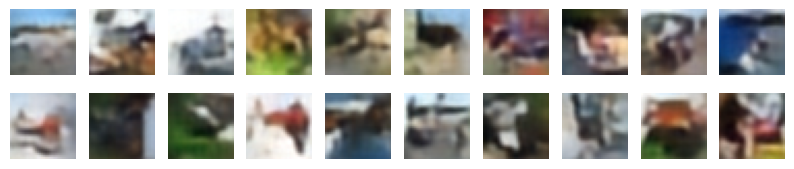

In [160]:
cnt = 0

fig, ax = plt.subplots(2, 10, figsize=(10, 2))

while cnt < 10:
    # Move data to device if using GPU
    x = inputs.to(device)  # Shape: [batch_size, 3, 32, 32]

    # Select an example image and reconstruction
    sampled_grid = sample_pixelcnn(pixelcnn)
    sample_image = denormalize(vq_new.decoder(vq_new.quantizer.embedding(sampled_grid.to(device)).permute(2, 0, 1).unsqueeze(0))[0]).detach().cpu().numpy()

    plt.sca(ax[1][cnt])
    plt.imshow(np.transpose(sample_image, (1, 2, 0)))
    plt.axis('off')

    sampled_grid = sample_pixelcnn(pixelcnn)
    sample_image = denormalize(vq_new.decoder(vq_new.quantizer.embedding(sampled_grid.to(device)).permute(2, 0, 1).unsqueeze(0))[0]).detach().cpu().numpy()
    plt.sca(ax[0][cnt])
    plt.imshow(np.transpose(sample_image, (1, 2, 0)))
    plt.axis('off')
    cnt += 1
plt.show()